In [350]:
import pandas as pd
import numpy as np
from google.cloud import bigquery

import plotly  
import plotly.graph_objs as go
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection   import train_test_split
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
import tscv as cv
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from fbprophet import Prophet
from sklearn.preprocessing import PolynomialFeatures
from pmdarima.arima import auto_arima

In [351]:
%load_ext google.cloud.bigquery
client = bigquery.Client()

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [352]:
sql = """SELECT date, location_key, country_code, country_name, aggregation_level, new_confirmed, 
        new_deceased, new_recovered, new_tested, cumulative_confirmed, cumulative_deceased,
        cumulative_recovered, cumulative_tested, new_hospitalized_patients, new_intensive_care_patients, 
        average_temperature_celsius, minimum_temperature_celsius, maximum_temperature_celsius 
        from covid19_open_data.covid19_open_data where location_key=country_code"""

In [353]:
df = client.query(sql).to_dataframe()

In [354]:
df_US_sim = df[df['location_key'] == 'US']

# Visualizations

In [355]:
df_US_sim['daily_change'] = df_US_sim.new_confirmed.pct_change()
round(df_US_sim['daily_change'], 2).quantile(0.05)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



-0.31

In [356]:
# print(test_lst)
test_lst = list(df_US_sim['daily_change'])
new_test_lst = []
for items in test_lst:
    if items == float('nan') or items == float('inf'):
        new_test_lst.append(0.0)
    else:
        new_test_lst.append(items)
df_US_sim['daily_change'] = new_test_lst
df_US_sim['daily_change'] = df_US_sim['daily_change'].fillna(0.0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<Figure size 432x288 with 0 Axes>

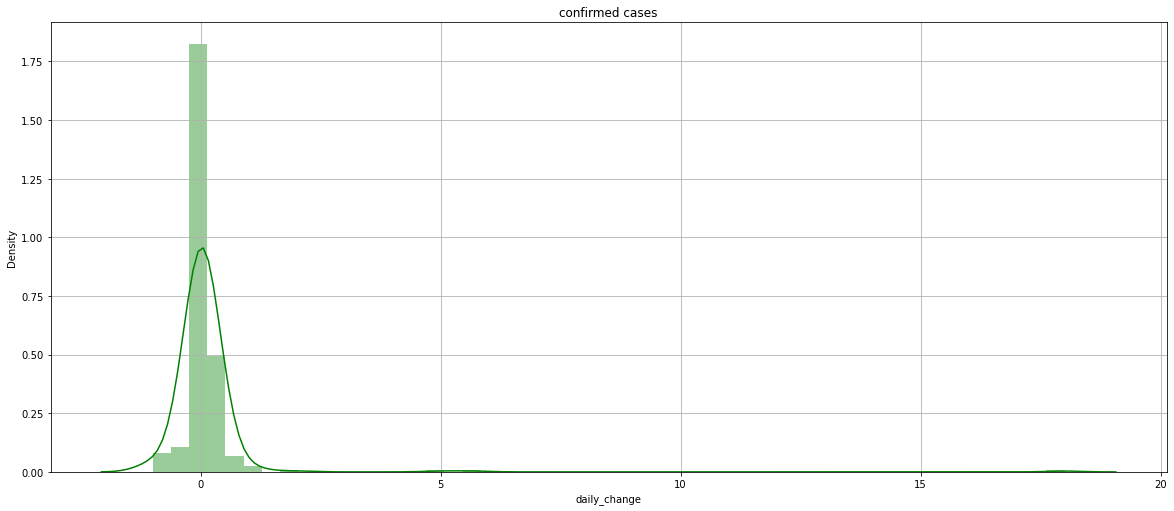

In [357]:
sns.despine(left=True)

#plot a simple histogram with binsize determined automatically
# plt.Figure(figsize=(20,10))
a4_dims = (20, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.distplot(df_US_sim['daily_change'], color="green")
plt.title('confirmed cases')
plt.grid(True)
plt.show()

### With 95% confidence, the daily increase in Covid cases will not exceed 31% of the previous day's confirmed cases

### If we have 10,000 cases today, our one-day 31% VaR is 0.31 * 10,000 = 3100

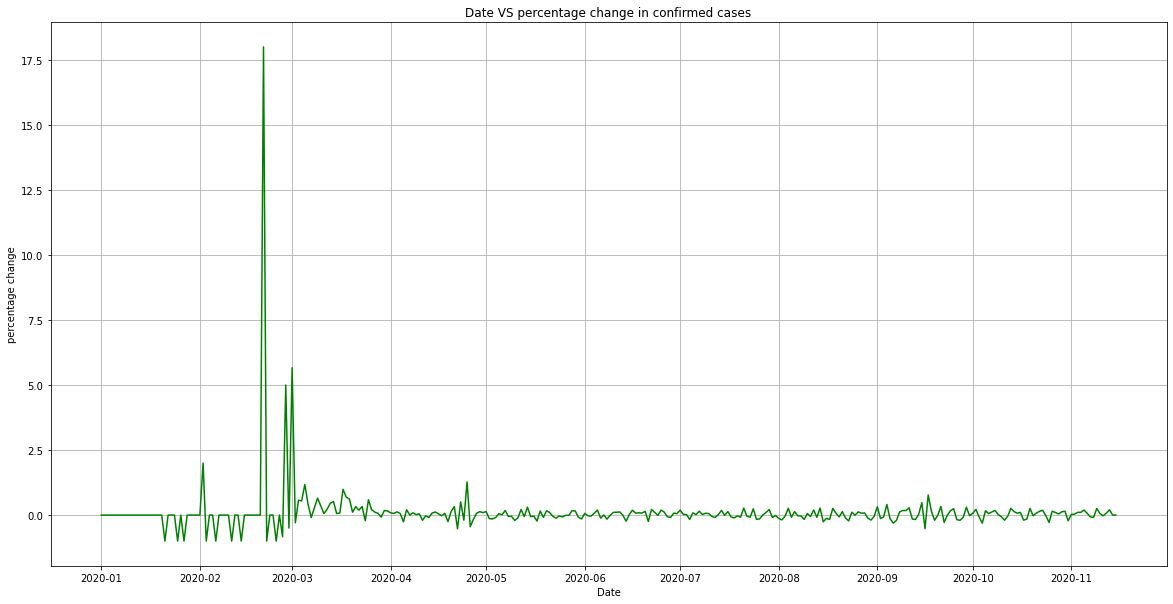

In [358]:
df_US_sim_ind = df_US_sim.set_index('date')
df_US_sim_ind['daily_change'].plot(figsize = (20, 10), color="green", grid = True)
plt.xlabel("Date")
plt.ylabel("percentage change")
plt.title("Date VS percentage change in confirmed cases")
plt.show()

# Feature Engineering
## Adding Weeks, Months and Year Columns

In [359]:
df_US_sim_ind.index = pd.to_datetime(df_US_sim_ind.index, errors='coerce')
df_US_sim_ind['day_of_week'] = df_US_sim_ind.index.dayofweek
df_US_sim_ind['day_of_month'] = df_US_sim_ind.index.day
df_US_sim_ind['quarter'] = df_US_sim_ind.index.quarter
df_US_sim_ind['month'] = df_US_sim_ind.index.month
df_US_sim_ind['year'] = df_US_sim_ind.index.year

## Adding Summary of the values at previous Time Steps

In [360]:
width = 3
shifted = df_US_sim_ind['new_confirmed'].shift(width - 1)
roll_window = shifted.rolling(window=width)
df_US_sim_ind['min'] = roll_window.min()
df_US_sim_ind['mean'] = roll_window.mean()
df_US_sim_ind['max'] = roll_window.max()
# df_US_sim_ind

In [361]:
df_pred = df_pred.drop(columns=['prediction'])

In [362]:
df_pred = df_US_sim_ind.copy()
n = int(30)
future_pred = n
df_pred = df_pred[:-2]
# Create another column (the target/ dependent variable) shifted 'n' units up
df_pred['prediction'] = df_pred['cumulative_confirmed'][:-n]
df_pred['prediction'] = df_pred['prediction'].fillna(0)

In [363]:
df_pred = df_pred.drop(columns=['cumulative_recovered', 'new_recovered'])
df_pred = df_pred.fillna(0)
df_pred.columns

Index(['location_key', 'country_code', 'country_name', 'aggregation_level',
       'new_confirmed', 'new_deceased', 'new_tested', 'cumulative_confirmed',
       'cumulative_deceased', 'cumulative_tested', 'new_hospitalized_patients',
       'new_intensive_care_patients', 'average_temperature_celsius',
       'minimum_temperature_celsius', 'maximum_temperature_celsius',
       'daily_change', 'day_of_week', 'day_of_month', 'quarter', 'month',
       'year', 'min', 'mean', 'max', 'prediction'],
      dtype='object')

In [364]:
X = np.array(df_pred.drop(columns = ['location_key','country_code','country_name','aggregation_level'
                                    ,'new_deceased','cumulative_confirmed','cumulative_deceased','cumulative_tested'
                                    ,'minimum_temperature_celsius',
                                   'maximum_temperature_celsius', 'daily_change', 'day_of_week',
                                   'day_of_month', 'quarter', 'month', 'year', 'min', 'mean', 'max',
                                   'prediction'],axis=1))

In [365]:
# X_sim = df_pred.drop(columns = ['location_key','country_code','country_name','aggregation_level'
#                                     ,'new_deceased','cumulative_confirmed','cumulative_deceased','cumulative_tested'
#                                     ,'minimum_temperature_celsius',
#                                    'maximum_temperature_celsius', 'daily_change', 'day_of_week',
#                                    'day_of_month', 'quarter', 'month', 'year', 'min', 'mean', 'max',
#                                    'prediction'],axis=1)
# X_sim.columns

In [366]:
X_forecast = X[-future_pred:]
X = X[:-future_pred]
y = np.array(df_pred['prediction'])
y = y[:-future_pred]
X.shape

(288, 5)

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print("Time series length: ",len(X_train))
print("Number of time series: ", len(X_train[0,1:]))

Time series length:  201
Number of time series:  4


# Time-Series Cross Validation (tscv)

In [368]:
cv = cv.GapKFold(n_splits=2, gap_before=1, gap_after=1)

# XGBOOST

In [369]:
reg = xgb.XGBRegressor(objective = 'reg:squarederror', n_jobs=-1)
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [370]:
confidence = reg.score(X_test, y_test)
print("Confidence %: ", round(confidence*100,2))
print('\n')
prediction = reg.predict(X_forecast)
print('\033[4mExpected confirmed cases for next 30 days\033[0m')
prediction = prediction
print(prediction)
print('\n')

rmse = np.sqrt(mean_squared_error(y_test[:future_pred], prediction[:future_pred]))
print('Test RMSE: %.3f' % rmse)
print('\n')
model_scores = []
model_scores.append(rmse)

Confidence %:  81.59


Expected confirmed cases for next 30 days
[7219968.5 6183053.  7243789.5 6320265.5 7522418.  7443611.5 7132097.5
 7058308.5 6746366.  6463463.5 6922553.  7061081.5 7071210.5 7053675.5
 7050367.  6769853.  6434657.5 6235634.5 6769853.  7072609.  7079097.5
 7077920.5 6671381.5 6421600.  6936510.  1997876.4  582963.9  582963.9
  582963.9  582963.9]


Test RMSE: 4739869.331




# Linear Regression

In [371]:
reg1 = lm.LinearRegression()
reg1.fit(X_train, y_train)

LinearRegression()

In [372]:
confidence1 = reg1.score(X_test, y_test)
print("Confidence %: ", round(confidence1*100,2))
print('\n')
prediction1 = reg1.predict(X_forecast)
print('\033[4mExpected confirmed cases for next 30 days\033[0m')
print(prediction1)
print('\n')

rmse1 = np.sqrt(mean_squared_error(y_test[:future_pred], prediction1[:future_pred]))
print('Test RMSE: %.3f' % rmse1)
print('\n')
model_scores.append(rmse)

Confidence %:  79.06


Expected confirmed cases for next 30 days
[7389381.26686581 6212660.57161526 4161880.02675362 4915436.54421597
 7026504.7590354  8157538.65453242 8577460.17342801 8268384.93529967
 6712166.50910559 4636830.50122199 5543846.01026583 7652304.1122604
 8379385.94464859 8318119.14749796 8451461.35944822 6792871.1070763
 5004440.85620012 5574509.54601728 6838381.73730386 7790155.66990748
 7681086.52324496 7120405.29865471 6294919.19048459 4108961.87431411
 3882685.83127709 2453932.9215645  -276418.33507272 -246228.67850493
 -276447.33579549 -329030.33855941]


Test RMSE: 4634078.466




# Randon Forest

In [373]:
regr = RandomForestRegressor(max_depth=4, random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, random_state=0)

In [374]:
confidence3 = regr.score(X_test, y_test)
print("Confidence %: ", round(confidence3*100,2))
print('\n')
prediction3 = regr.predict(X_forecast)
print('\033[4mExpected confirmed cases for next 30 days\033[0m')
print(prediction3)
print('\n')

rmse3 = np.sqrt(mean_squared_error(y_test[:future_pred], prediction3[:future_pred]))
print('Test RMSE: %.3f' % rmse3)
print('\n')
model_scores.append(rmse)

Confidence %:  83.49


Expected confirmed cases for next 30 days
[7084673.01986755 6203443.1079636  6337729.36122323 6379904.50934232
 6896105.44940909 7091659.34957664 7091659.34957664 7067699.54077664
 6558370.43915348 6141717.20939853 6144140.97189298 7054355.97539111
 7067699.54077664 7067699.54077664 7067699.54077664 6874600.09060909
 6148118.11970128 6127213.68309298 6874600.09060909 7134167.74011114
 7134167.74011114 7128876.81363037 6608147.78134513 6158084.16003103
 6164111.52985621 2144242.76988608  554477.64131594  554477.64131594
  554477.64131594  554477.64131594]


Test RMSE: 4603277.415




### Dropping the rows at the beginning of this year which has 0 cumulative confirmed 

In [375]:
df_US_sim_ARM = df_US_sim[['date','cumulative_confirmed']]
df_US_sim_ARM = df_US_sim_ARM[:-2] # dropping today and yesterday rows/values
df_US_sim_ARM = df_US_sim_ARM.loc[~(df_US_sim_ARM['cumulative_confirmed'] == 0.0)]
df_US_sim_ARM.head()

,date,cumulative_confirmed
20177,2020-01-18,5.0
20178,2020-01-19,5.0
20179,2020-01-20,1.0
20180,2020-01-21,1.0
20181,2020-01-22,1.0


## Holts

In [376]:
from datetime import datetime, timedelta

valid_set = df_US_sim_ARM[-31:]
train_set = df_US_sim_ARM[:-31]

begin_date = valid_set.iloc[[-1]].date
begin_date = begin_date + timedelta(days=1)
begin_date = begin_date.to_string()[9:]
print(begin_date)
# begin_date = '2020-11-14'
df_date = pd.DataFrame({'cumulative_confirmed':0, 
                      'date':pd.date_range(begin_date, periods=90)})
test_set = valid_set.append(df_date, ignore_index=True)
test_set['date'] = pd.to_datetime(test_set['date'] ,errors = 'coerce',format = '%Y-%m-%d')
test_set = test_set.set_index('date')

2020-11-14


In [377]:
model_train = train_set.set_index('date')  # only training set without last 30 rows
valid = valid_set.set_index('date') # only validation set with only last 30 rows
y_pred=test_set.copy() # validation set + test set with last 30 rows + additional 90 rows/dates

In [378]:
holt=Holt(np.asarray(model_train["cumulative_confirmed"])).fit(smoothing_level=0.3, smoothing_slope=0.3,optimized=False) 

In [379]:

y_pred["Holt"]=holt.forecast(len(test_set))
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt"][:valid.shape[0]-1])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt"][:valid.shape[0]-1])))

Root Mean Square Error Holt's Linear Model:  510568.08911942056


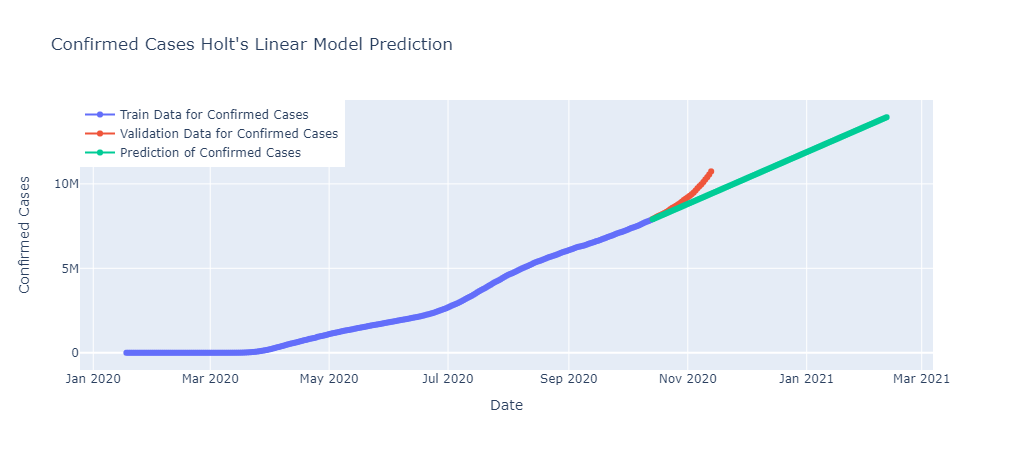

In [380]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### Holt's Winter Model for Daily Time Series

In [381]:
model_train['cumulative_confirmed_winter'] = model_train['cumulative_confirmed'].astype(int)
model_train['cumulative_confirmed_winter'] = model_train['cumulative_confirmed'].abs()
# model_train['cumulative_confirmed_winter'] = model_train['cumulative_confirmed'].replace(0,1)

In [382]:
model_train

,cumulative_confirmed,cumulative_confirmed_winter
date,,
2020-01-18,5.0,5.0
2020-01-19,5.0,5.0
2020-01-20,1.0,1.0
2020-01-21,1.0,1.0
2020-01-22,1.0,1.0
...,...,...
2020-10-09,7664676.0,7664676.0
2020-10-10,7718947.0,7718947.0
2020-10-11,7762544.0,7762544.0


In [383]:
es=ExponentialSmoothing(np.asarray(model_train['cumulative_confirmed_winter']),seasonal_periods=7,trend='add', seasonal='add').fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [384]:
len(test_set)

121

In [385]:
y_pred["Holt's Winter Model"]=es.forecast(len(test_set))
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt's Winter Model"][:valid.shape[0]-1])))
print("Root Mean Square Error for Holt's Winter Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["Holt's Winter Model"][:valid.shape[0]-1])))

Root Mean Square Error for Holt's Winter Model:  461543.8620901662


In [386]:
model_train

,cumulative_confirmed,cumulative_confirmed_winter
date,,
2020-01-18,5.0,5.0
2020-01-19,5.0,5.0
2020-01-20,1.0,1.0
2020-01-21,1.0,1.0
2020-01-22,1.0,1.0
...,...,...
2020-10-09,7664676.0,7664676.0
2020-10-10,7718947.0,7718947.0
2020-10-11,7762544.0,7762544.0


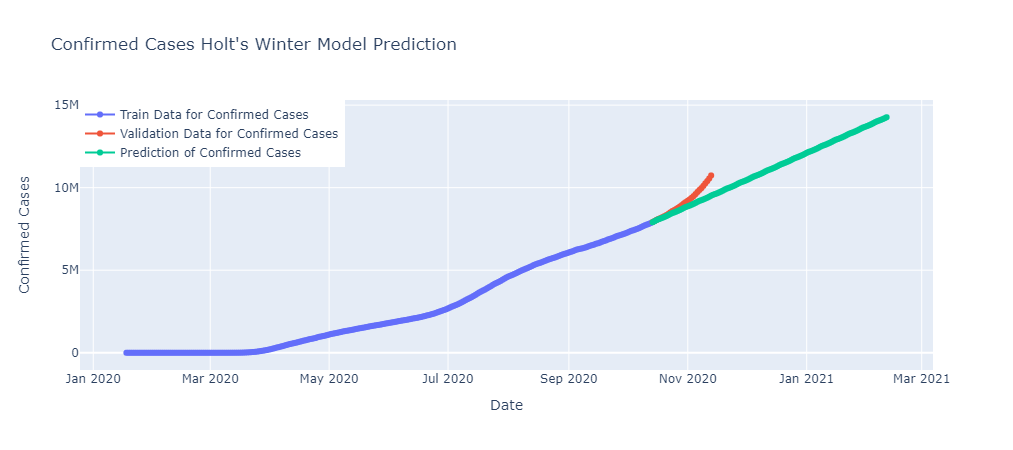

In [387]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed_winter"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["Holt's Winter Model"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Winter Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

In [388]:
y_pred["Holt's Winter Model"] = y_pred["Holt's Winter Model"].astype(int)
y_pred["Holt"] = y_pred["Holt"].astype(int)

In [389]:
y_pred

,cumulative_confirmed,Holt,Holt's Winter Model
date,,,
2020-10-14,7916100.0,7906176,7908379
2020-10-15,7979885.0,7956504,7968196
2020-10-16,8050141.0,8006831,8033561
2020-10-17,8106752.0,8057159,8088992
2020-10-18,8154595.0,8107486,8131150
...,...,...,...
2021-02-07,0.0,13744163,14057265
2021-02-08,0.0,13794491,14101790
2021-02-09,0.0,13844818,14152654


# AR Model (using AUTO ARIMA)

In [390]:
model_ar= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=4,max_q=0,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ar.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5440.501, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5425.069, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5416.252, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=5403.096, Time=0.06 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=5398.005, Time=0.13 sec
Total fit time: 0.259 seconds


ARIMA(order=(4, 2, 0), scoring_args={}, suppress_warnings=True)

In [391]:
prediction_ar=model_ar.predict(len(test_set))
y_pred["AR Model Prediction"]=prediction_ar

In [392]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["AR Model Prediction"][:valid.shape[0]-1])))
print("Root Mean Square Error for AR Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["AR Model Prediction"][:valid.shape[0]-1])))

Root Mean Square Error for AR Model:  469409.9975181326


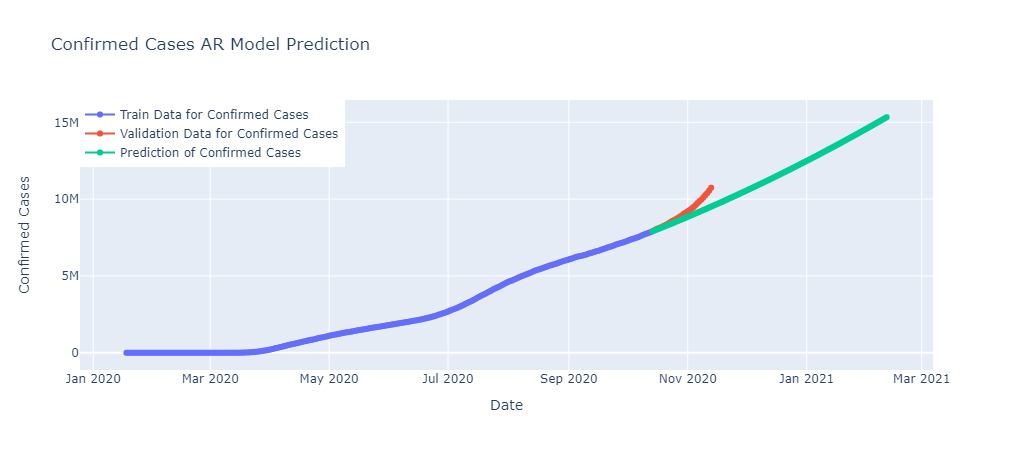

In [393]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["AR Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases AR Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### MA Model (using AUTO ARIMA)

In [394]:
model_ma= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=0,max_q=2,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_ma.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5440.501, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=5404.780, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=5397.146, Time=0.06 sec
Total fit time: 0.114 seconds


ARIMA(order=(0, 2, 2), scoring_args={}, suppress_warnings=True)

In [395]:
prediction_ma=model_ma.predict(len(test_set))
y_pred["MA Model Prediction"]=prediction_ma

In [396]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_ma[:valid.shape[0]-1])))
print("Root Mean Square Error for MA Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_ma[:valid.shape[0]-1])))

Root Mean Square Error for MA Model:  402663.7053215682


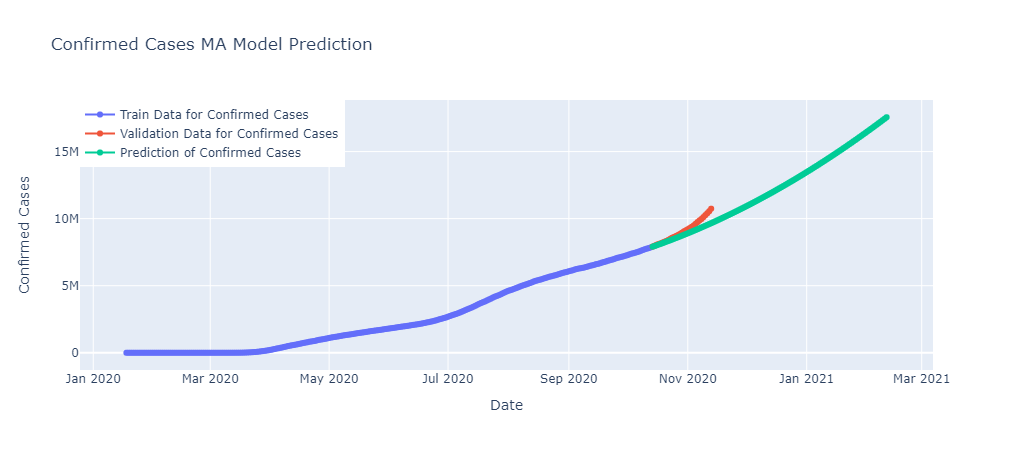

In [397]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["MA Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases MA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### ARIMA Model (using AUTOARIMA)

In [398]:
model_arima= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5440.501, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=5404.780, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=5397.146, Time=0.10 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=5400.984, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5425.069, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=5397.558, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=5400.117, Time=0.11 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=5375.323, Time=0.70 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5416.252, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=5394.256, Time=0.22 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=5396.673, Time=0.62 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=5348.817, Time=0.83 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=5403.096, Time=0.10 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=5387.673, Time=0.15 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=5393.058, Time=0.24 sec
Total fit 

ARIMA(order=(2, 2, 3), scoring_args={}, suppress_warnings=True)

In [399]:
prediction_arima=model_arima.predict(len(test_set))
y_pred["ARIMA Model Prediction"]=prediction_arima

In [400]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_arima[:valid.shape[0]-1])))
print("Root Mean Square Error for ARIMA Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],prediction_arima[:valid.shape[0]-1])))

Root Mean Square Error for ARIMA Model:  318989.4997088486


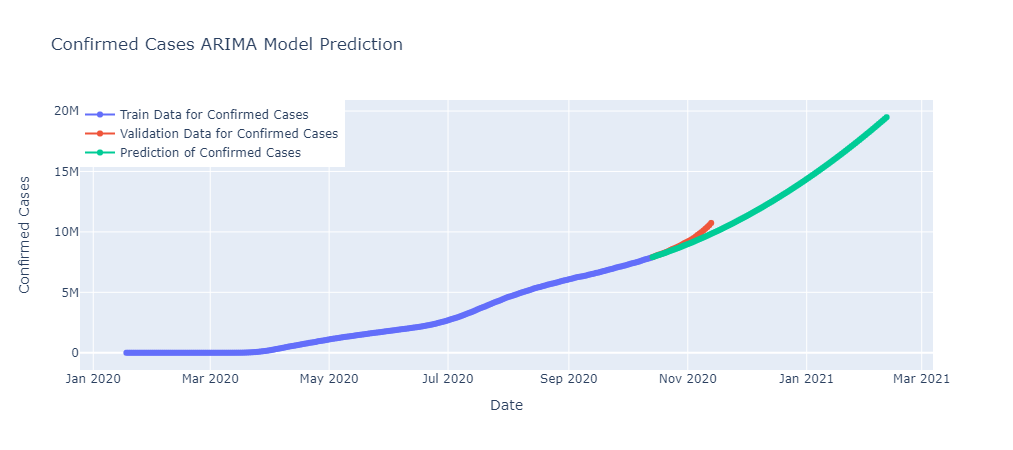

In [401]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["ARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases ARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### SARIMA Model (using AUTO ARIMA)

In [402]:
model_sarima= auto_arima(model_train["cumulative_confirmed"],trace=True, error_action='ignore', start_p=0,start_q=0,max_p=2,max_q=2,m=7,
                   suppress_warnings=True,stepwise=False,seasonal=False)
model_sarima.fit(model_train["cumulative_confirmed"])

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=5440.501, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=5404.780, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=5397.146, Time=0.07 sec


/opt/conda/lib/python3.7/site-packages/pmdarima/arima/_validation.py:60: UserWarning:

m (7) set for non-seasonal fit. Setting to 0



 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=5425.069, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=5397.558, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=5400.117, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=5416.252, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=5394.256, Time=0.16 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=5396.673, Time=0.75 sec
Total fit time: 1.322 seconds


ARIMA(order=(2, 2, 1), scoring_args={}, suppress_warnings=True)

In [403]:
type(prediction_sarima)

numpy.ndarray

In [404]:
prediction_sarima=model_sarima.predict(len(test_set))
y_pred["SARIMA Model Prediction"]=prediction_sarima

In [405]:
model_scores.append(np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["SARIMA Model Prediction"][:valid.shape[0]-1])))
print("Root Mean Square Error for SARIMA Model: ",np.sqrt(mean_squared_error(y_pred["cumulative_confirmed"][:valid.shape[0]-1],y_pred["SARIMA Model Prediction"][:valid.shape[0]-1])))

Root Mean Square Error for SARIMA Model:  429543.9192737118


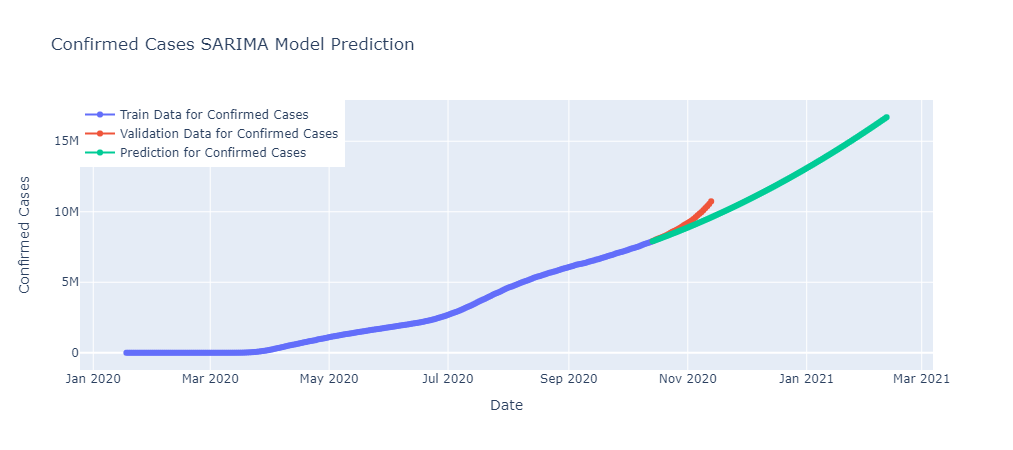

In [406]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["cumulative_confirmed"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=valid.index, y=valid["cumulative_confirmed"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred["SARIMA Model Prediction"],
                    mode='lines+markers',name="Prediction for Confirmed Cases",))
fig.update_layout(title="Confirmed Cases SARIMA Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

### Facebook's Prophet Model for forecasting

In [407]:
df_US_sim_FB = df_US_sim_ARM.set_index('date')

In [408]:
prophet_c=Prophet(interval_width=0.95,weekly_seasonality=True,)
prophet_confirmed=pd.DataFrame(zip(list(df_US_sim_FB.index),list(df_US_sim_FB["cumulative_confirmed"])),columns=['ds','y'])

In [409]:
prophet_c.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [410]:
forecast_c=prophet_c.make_future_dataframe(periods=len(test_set))
forecast_confirmed=forecast_c.copy()

In [411]:
confirmed_forecast=prophet_c.predict(forecast_c)

In [412]:
model_scores.append(np.sqrt(mean_squared_error(df_US_sim_FB["cumulative_confirmed"],confirmed_forecast['yhat'].head(df_US_sim_FB.shape[0]))))
print("Root Mean Squared Error for Prophet Model: ",np.sqrt(mean_squared_error(df_US_sim_FB["cumulative_confirmed"],confirmed_forecast['yhat'].head(df_US_sim_FB.shape[0]))))

Root Mean Squared Error for Prophet Model:  112945.9842093897


Figure(720x432)


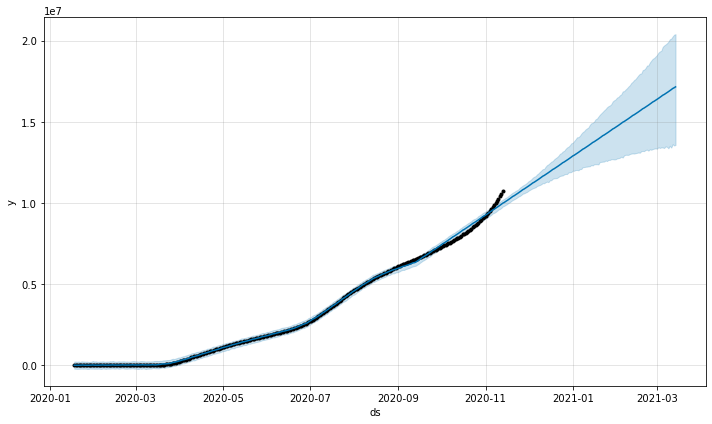

In [413]:
print(prophet_c.plot(confirmed_forecast))
y_pred["Facebook's Prophet"]=confirmed_forecast['yhat'][-121:].to_numpy().astype(int)
# confirmed_forecast['yhat']

In [414]:
# y_pred = y_pred[['cumulative_confirmed','AR Model Prediction','MA Model Prediction','ARIMA Model Prediction','SARIMA Model Prediction']].astype(int)

In [415]:
y_pred

,cumulative_confirmed,Holt,Holt's Winter Model,AR Model Prediction,MA Model Prediction,ARIMA Model Prediction,SARIMA Model Prediction,Facebook's Prophet
date,,,,,,,,
2020-10-14,7916100.0,7906176,7908379,7.909837e+06,7.908594e+06,7.912612e+06,7.909075e+06,10021215
2020-10-15,7979885.0,7956504,7968196,7.962045e+06,7.959906e+06,7.971369e+06,7.960069e+06,10078457
2020-10-16,8050141.0,8006831,8033561,8.011944e+06,8.011707e+06,8.029148e+06,8.011114e+06,10136333
2020-10-17,8106752.0,8057159,8088992,8.061475e+06,8.063997e+06,8.083472e+06,8.062728e+06,10197166
2020-10-18,8154595.0,8107486,8131150,8.112449e+06,8.116776e+06,8.134977e+06,8.114813e+06,10258951
...,...,...,...,...,...,...,...,...
2021-02-07,0.0,13744163,14057265,1.503726e+07,1.712343e+07,1.893478e+07,1.632152e+07,16914971
2021-02-08,0.0,13794491,14101790,1.510979e+07,1.723149e+07,1.907137e+07,1.641601e+07,16979636
2021-02-09,0.0,13844818,14152654,1.518251e+07,1.734003e+07,1.920851e+07,1.651088e+07,17048696


In [416]:
model_names=["XGBoost","Linear Regression","Random Forest Regressor","Holt's Linear","Holt's Winter Model",
            "Auto Regressive Model (AR)","Moving Average Model (MA)","ARIMA Model","SARIMA Model","Facebook's Prophet Model"]
model_summary=pd.DataFrame(zip(model_names,model_scores),columns=["Model Name","Root Mean Squared Error"]).sort_values(["Root Mean Squared Error"])
model_summary['Root Mean Squared Error'] = model_summary['Root Mean Squared Error'].astype(int)
model_summary

,Model Name,Root Mean Squared Error
9,Facebook's Prophet Model,112945
7,ARIMA Model,318989
6,Moving Average Model (MA),402663
8,SARIMA Model,429543
4,Holt's Winter Model,461543
5,Auto Regressive Model (AR),469409
3,Holt's Linear,510568
0,XGBoost,4739869
1,Linear Regression,4739869
2,Random Forest Regressor,4739869
